In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

## Autoregression
A regression model, such as linear regression, models an output value based on a linear
combination of input values. For example:

$$yhat = b_0 + (b_1 \times X_1)$$

Where yhat is the prediction, b0 and b1 are coefecients found by optimizing the model on
training data, and X is an input value. This technique can be used on time series where input
variables are taken as observations at previous time steps, called lag variables. For example, we
can predict the value for the next time step (t+1) given the observations at the current (t and
previous t-1). As a regression model, this would look as follows:

$$X(t+1) = b_0 + (b_1 \times X(t)) + (b_2 \times X(t-1))$$

Because the regression model uses data from the same input variable at previous time steps,
it is referred to as an autoregression (regression of self).

## Autocorrelation

An autoregression model makes an assumption that the observations at current and previous time steps are useful to predict the value at the next time step. This relationship between variables is called correlation. If both variables change in the same direction (e.g. go up together or down together), this is called a positive correlation. If the variables move in opposite directions as values change (e.g. one goes up and one goes down), then this is called negative correlation.

We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling. Again, because the correlation is calculated between the variable and itself at previous time steps, it is called an autocorrelation. It is also called serial correlation because of the sequenced structure of time series data.

In [7]:
import re

df = pd.read_csv('./dataset/daily-minimum-temperatures-in-me.csv', parse_dates=['Date'], index_col='Date')
df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: re.sub(r'\?', '', x)).astype(float)
df.head()

,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


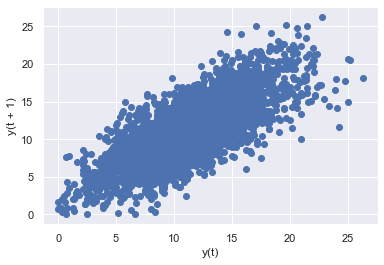

In [12]:
from pandas.plotting import lag_plot

lag_plot(df)
plt.show()

In [29]:
new_df = pd.DataFrame(
    {
        't':df.iloc[:, 0].shift(1),
        't+1':df.values.flatten()
    }
)
new_df.corr()

,t,t+1
t,1.00000,0.77487
t+1,0.77487,1.00000


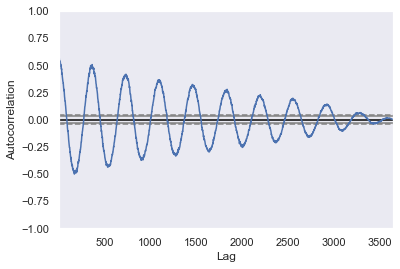

In [30]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df)
plt.show()

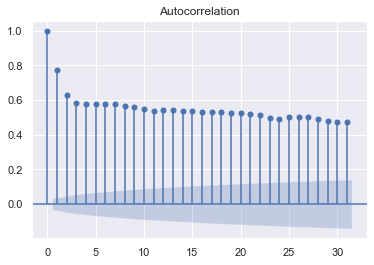

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
_ = plot_acf(df, lags=31)

## Persistence Model
Let's say that we want to develop a model to predict the last 7 days of minimum temperatures
in the dataset given all prior observations. The simplest model that we could use to make
predictions would be to persist the last observation. We can call this a persistence model and
it provides a baseline of performance for the problem that we can use for comparison with an
autoregression model.
We can develop a test harness for the problem by splitting the observations into training
and test sets, with only the last 7 observations in the dataset assigned to the test set as unseen
data that we wish to predict. The predictions are made using a walk-forward validation model
so that we can persist the most recent observations for the next day. This means that we are
not making a 7-day forecast, but 7 1-day forecasts.

In [43]:
new_df

,t,t+1
Date,,
1981-01-01,NaN,20.7
1981-01-02,20.7,17.9
1981-01-03,17.9,18.8
1981-01-04,18.8,14.6
1981-01-05,14.6,15.8
...,...,...
1990-12-27,14.6,14.0
1990-12-28,14.0,13.6
1990-12-29,13.6,13.5


In [48]:
from sklearn.model_selection import TimeSeriesSplit

X = new_df.values
splits = TimeSeriesSplit(n_splits=3)
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print(f'train: {len(train)}, test: {len(test)}')

X_train, y_train = train[:, 0], train[:, 1]
X_test, y_test = test[:, 0], test[:, 1]

train: 914, test: 912
train: 1826, test: 912
train: 2738, test: 912


Test RMSE 2.6489405363111267


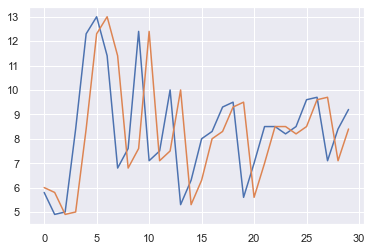

In [53]:
from sklearn.metrics import mean_squared_error

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = []
for x in X_test:
    y_pred = model_persistence(x)
    predictions.append(y_pred)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Test RMSE {rmse}')

plt.plot(y_test[:30])
plt.plot(predictions[:30])
plt.show()

## Autoregression Model

An autoregression model is a linear regression model that uses lagged variables as input variables.
We could calculate the linear regression model manually using the LinearRegession class in
scikit-learn and manually specify the lag input variables to use. Alternately, the Statsmodels
library provides an autoregression model that automatically selects an appropriate lag value
using statistical tests and trains a linear regression model. It is provided in the AR class.

In [3]:
from statsmodels.tsa.ar_model import AR

X = new_df.values[1:]
train, test = X[1:len(X)-7], X[len(X)-7:]

# train AR model 
model = AR(train)
model_fit = model.fit()

print(f'Lag: {model_fit.k_ar}')
print(f'Coefficients: {model_fit.params}')

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

NameError: name 'new_df' is not defined